# Introduction to Bayesian modelling in PyMC

This is code from Chris Fonnesbeck's Talk at PyData London 2022.

His notebook here:
 - https://github.com/fonnesbeck/probabilistic_python

Video here:
 - https://www.youtube.com/watch?v=911d4A1U0BE&list=PLD1x-BW9UdeGu5nn1gSPeAxTYeclfDTBD&index=4

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

random_seed = 42
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/probabilistic_python/master/data/"

## Load data

In [2]:
try:
    spin_rate_data
except NameError:
    try:
        spin_rate_data = pd.read_csv('./data/savant_data.csv', parse_dates=['game_date']).dropna(subset=['spin_rate', 'game_date'])
    except FileNotFoundError:
        spin_rate_data = pd.read_csv(DATA_URL + 'savant_data.csv', parse_dates=['game_date']).dropna(subset=['spin_rate', 'game_date'])

spin_rate_data.shape

(7791, 32)

In [3]:
spin_rate_data.head()

,pitches,player_id,player_name,game_date,total_pitches,pitch_percent,ba,iso,babip,slg,...,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,47,450203,"Morton, Charlie",2021-07-16,107,43.9,0.077,0.077,0.167,0.154,...,28,0.1,6.36,111.0,148.0,139.0,134.0,299.0,320.0,300.0
1,47,621244,"Berríos, José",2021-05-08,104,45.2,0.143,0.286,0.143,0.429,...,28,-0.2,6.31,101.0,148.0,112.0,145.0,295.0,332.0,297.0
2,46,450203,"Morton, Charlie",2021-06-17,112,41.1,0.000,0.000,0.000,0.000,...,20,-0.4,6.21,105.0,151.0,134.0,137.0,314.0,322.0,291.0
3,45,450203,"Morton, Charlie",2021-08-31,106,42.5,0.100,0.000,0.143,0.100,...,26,-0.4,6.16,114.0,153.0,139.0,143.0,296.0,317.0,298.0
4,45,450203,"Morton, Charlie",2021-06-22,107,42.1,0.000,0.000,NaN,0.000,...,27,-0.8,6.28,107.0,149.0,135.0,135.0,290.0,304.0,291.0


<Axes: xlabel='game_date', ylabel='spin_rate'>

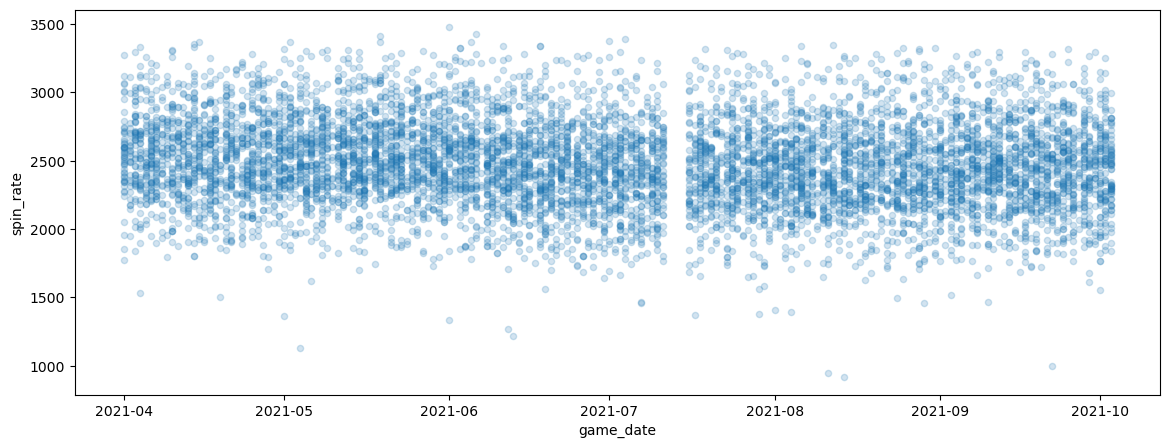

In [4]:
spin_rate_data.plot.scatter(x='game_date', y='spin_rate', figsize=(14,5), alpha=0.2)

In [5]:
# Select desired data
day_ind, date = pd.factorize(spin_rate_data.game_date, sort=True)
spin_rate = spin_rate_data.spin_rate.values

## Build model

To represent the hypothesis that spin rates differed before and after the MLB crackdown on sticky stuff, we will implement a changepoint model. In its simplest form, this is a piecewise-constant model, with an early and late population mean, separated by a discrete changepoint.

$$
r_t = \left\{
\begin{array}{lll}
\mu_1 & \text{if} & t \lt \tau \\
\mu_2 & \text{if} & t \ge \tau
\end{array}
\right.
$$

The pitch spin rates on either side of the changepoint can then be modeled as normally-distributed with either the early or late mean. These are our sampling distributions, or likelihoods.

$$
    y_i^{(pre)} \sim \text{Normal}(\mu_1, \sigma) \\
    y_i^{(post)} \sim \text{Normal}(\mu_2, \sigma)
$$

Assign prior distributions

$$\mu_i \sim \text{Normal}(2500, 100)$$
$$\tau \sim \text{Uniform}(0, T)$$
$$\sigma \sim \text{HalfNormal}(100)$$

### Unobserved random variables

In [6]:
with pm.Model() as spin_rate_model:

    mu = pm.Normal('mu', mu=2500, sigma=100, shape=2)  # There are 2
    tau = pm.Uniform('tau', lower=day_ind.min(), upper=day_ind.max())
    sigma = pm.HalfNormal('sigma', 100.)

In [7]:
# Days are encoded as integers
day_ind.min(), day_ind.max()

(0, 181)

In [8]:
type(mu)

pytensor.tensor.var.TensorVariable

Note: The latest version of PyMC uses a new probabilistic programming engine called Aesara, which is a reincarnation of the now-extinct Theano.

In [9]:
# Example: get the log probability of a value
pm.logp(tau, 5).eval()

array(-5.19849703)

In [10]:
# Sample from the variable's distribution
pm.draw(tau)

array(137.86682006)

(array([261., 259., 188., 122.,  75.,  57.,  20.,  14.,   3.,   1.]),
 array([6.55867281e-02, 3.32343586e+01, 6.64031304e+01, 9.95719023e+01,
        1.32740674e+02, 1.65909446e+02, 1.99078218e+02, 2.32246990e+02,
        2.65415762e+02, 2.98584533e+02, 3.31753305e+02]),
 <BarContainer object of 10 artists>)

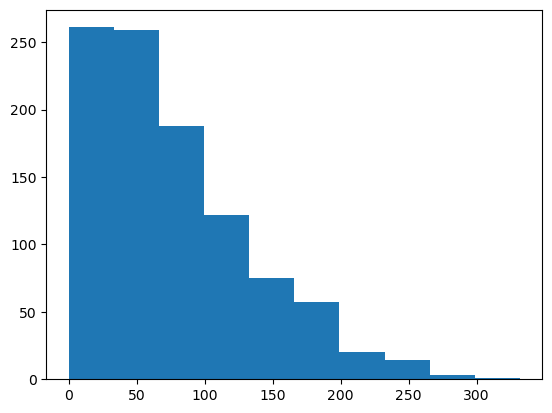

In [11]:
plt.hist(pm.draw(sigma, 1000))

In [12]:
# Summary of model's random variables
spin_rate_model.unobserved_RVs

[mu ~ N(2.5e+03, 100), tau ~ U(0, 181), sigma ~ N**+(0, 100)]

### Deterministic

The variable $r$ is completely determined by the values of its parents. There is no inherenet randomness, except that which comes from the variables it depends on.

In [13]:
with spin_rate_model:

    r = pm.math.switch(tau >= day_ind, mu[0], mu[1])

Note: No name was given to this variable because it's simply an intermediate variable that we are not interested in, i.e. anonymous.  If you want it to persist and be included in the results at the end you would have to wrap it in a `pm.Deterministic` object with a name:

```lang-python
r = pm.Deterministic('r', pm.math.switch(tau >= day_ind, mu[0], mu[1]))
```

The size of r is determined by the number of pitches thrown in the data set.

In [17]:
r.shape.eval()

array([7791])

### Observered random variables (The likelihood)

The only difference between stochastic and observed variables in the model is that one has data associated with it.  This is done by passing the data to the distribution using the `observed` keyword argument.

In [14]:
with spin_rate_model:

    spin_rate_like = pm.Normal('spin_rate_like', mu=r, sigma=sigma, 
                               observed=spin_rate)

In [15]:
spin_rate_model.observed_RVs

[spin_rate_like ~ N(f(tau, mu), sigma)]

Note, similar to `r`, `spin_rate_like` is a vector of spin_rates for every pitch.

In [ ]:
spin_rate_like.shape.eval()

array([7791])

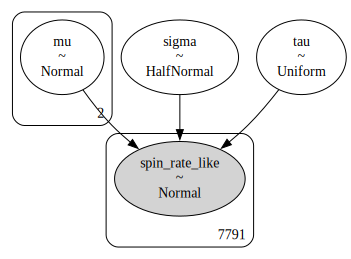

In [16]:
pm.model_to_graphviz(spin_rate_model)

### Do inference

This can be done very simply (using default parameters)

In [20]:
# Warning: This may take about 20 minutes!
with spin_rate_model:

    trace = pm.sample()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1152 seconds.


array([<Axes: title={'center': 'mu\n0'}>,
       <Axes: title={'center': 'mu\n1'}>, <Axes: title={'center': 'tau'}>],
      dtype=object)

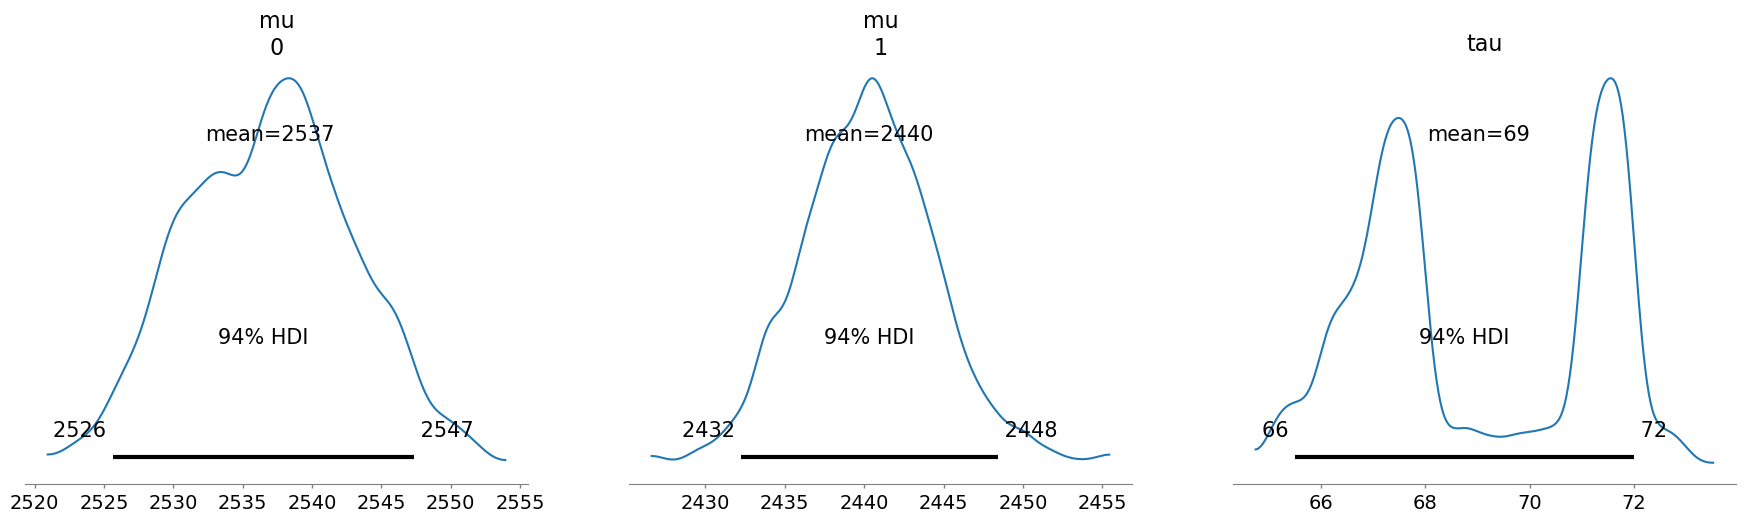

In [21]:
az.plot_posterior(trace, var_names=['mu', 'tau'])

In [66]:
# Date where mean was located
date[69]

Timestamp('2021-06-09 00:00:00')

This is less than a week after they changed the regulation!

In [30]:
# Size of difference
trace.posterior

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, mu_dim_0: 2)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int64 0 1
Data variables:
    mu        (chain, draw, mu_dim_0) float64 2.534e+03 2.428e+03 ... 2.44e+03
    tau       (chain, draw) float64 72.69 72.98 72.97 ... 67.32 67.33 67.89
    sigma     (chain, draw) float64 315.8 315.8 315.8 ... 311.6 311.1 311.5
Attributes:
    created_at:                 2023-03-02T20:32:09.659413
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2
    sampling_time:              1152.4544508457184
    tuning_steps:               1000

In [31]:
# Save results to file
trace.to_netcdf("sticky_balls.nc")

'sticky_balls.nc'

To Re-load the results later use this:
````
trace = az.from_netcdf("sticky_balls.nc")
````

In [43]:
trace.posterior.mu.values.shape

(4, 1000, 2)

In [59]:
trace.posterior.mu.shape

(4, 1000, 2)

In [67]:
# Size of difference in means (rpm before / after)
trace.posterior.mu.values.mean(axis=(0, 1))

array([2536.95826276, 2440.2859765 ])